## Predict

In [1]:
import os
import tensorflow as tf
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12532749410888504222
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 22881945600
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15606811152901371921
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:09:00.0, compute capability: 8.6"
]


In [2]:
%env SM_FRAMEWORK=tf.keras
import warnings
warnings.filterwarnings("ignore")
import os
import gc
import cv2
import json
import time
import random
import numpy as np
import pandas as pd
import tifffile as tiff
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import albumentations as albu
from sklearn.model_selection import train_test_split, KFold, GroupKFold
import tensorflow.keras.backend as K
from tensorflow.keras import Model, Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import *
import segmentation_models as sm
from segmentation_models import Unet, FPN
from segmentation_models.losses import bce_jaccard_loss
print("tensorflow version:", tf.__version__)
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
if gpu_devices:
    for gpu_device in gpu_devices:
        print("device available:", gpu_device)
#policy = tf.keras.mixed_precision.experimental.Policy("mixed_float16")
#tf.keras.mixed_precision.experimental.set_policy(policy)
pd.set_option("display.max_columns", None)
%matplotlib inline
import matplotlib.pyplot as plt
STRATEGY = tf.distribute.get_strategy()

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.
tensorflow version: 2.4.1
device available: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
VER = "v13"
MDLS_PATH = f"../models/models_{VER}"
with open(f"{MDLS_PATH}/params.json") as file:
    PARAMS = json.load(file)
print(f"loaded params: {PARAMS}")
DATA_PATH = "../input/hubmap-kidney-segmentation"

loaded params: {'version': 'v13', 'folds': 4, 'img_size': 256, 'resize': 4, 'batch_size': 32, 'epochs': 40, 'patience': 20, 'backbone': 'efficientnetb7', 'loss': 'bce_dice', 'mirror': False, 'umodel': 'unet', 'bce_weight': 1.0, 'shift': True, 'pseudo': '', 'lr': 0.0002, 'split': 'kfold', 'seed': None}


In [4]:
def dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred, smooth = 1):
    return (1 - dice_coef(y_true, y_pred))

def bce_dice_loss(y_true, y_pred):
    return PARAMS["bce_weight"] * binary_crossentropy(y_true, y_pred) + \
        (1 - PARAMS["bce_weight"]) * dice_loss(y_true, y_pred)

def get_model(backbone, input_shape, loss_type = "bce_dice", umodel = "unet", classes = 1, lr = PARAMS["lr"]):
    with STRATEGY.scope():
        if loss_type == "bce_dice":
            loss = bce_dice_loss
            
        else:
            raise AttributeError("loss mode parameter error")
            
        if umodel == "unet":
            model = Unet(backbone_name = backbone, encoder_weights = "imagenet",
                        input_shape = input_shape,
                        classes = classes, activation = "sigmoid")
        elif umodel == "fpn":
            model = FPN(backbone_name = backbone, encoder_weights = "imagenet",
                       input_shape = input_shape,
                       classes = classes, activation = "sigmoid")
        else:
            raise AttributeError("umodel mode parameter error")
        
        model.compile(
            optimizer = tfa.optimizers.Lookahead(
                tf.keras.optimizers.Adam(learning_rate = lr),
                sync_period = max(6, int(PARAMS["patience"] / 4))
            ),
            loss = loss,
            metrics = [dice_coef]
        )
        return model

In [5]:
df_masks = pd.read_csv(f"{DATA_PATH}/train.csv").set_index("id")
df_masks

,encoding
id,
2f6ecfcdf,296084587 4 296115835 6 296115859 14 296147109...
8242609fa,96909968 56 96941265 60 96972563 64 97003861 6...
aaa6a05cc,30989109 59 31007591 64 31026074 68 31044556 7...
cb2d976f4,78144363 5 78179297 15 78214231 25 78249165 35...
b9a3865fc,61271840 4 61303134 13 61334428 22 61365722 30...
b2dc8411c,56157731 21 56172571 45 56187411 51 56202252 5...
0486052bb,101676003 6 101701785 8 101727568 9 101753351 ...
e79de561c,7334642 14 7350821 41 7367001 67 7383180 82 73...
095bf7a1f,113277795 21 113315936 53 113354083 87 1133922...


In [6]:
larger = 4
test_models = []
for n_fold in list(range(PARAMS["folds"])):
    
    checkpoint_path = f"{MDLS_PATH}/model_{n_fold}.hdf5"
    print(checkpoint_path)
    model_lrg = get_model (
        PARAMS["backbone"],
        input_shape = (PARAMS["img_size"] * larger, PARAMS["img_size"] * larger, 3),
        loss_type = PARAMS["loss"],
        umodel = PARAMS["umodel"]
    )
    model_lrg.load_weights(checkpoint_path) # or .set_weights(model.get_weights()) from smaller model
    test_models.append(model_lrg)

./models_v13/model_0.hdf5
./models_v13/model_1.hdf5
./models_v13/model_2.hdf5
./models_v13/model_3.hdf5


In [7]:
def enc2mask(encs, shape):
    img = np.zeros(shape[0] * shape[1], dtype = np.uint8)
    for m, enc in enumerate(encs):
        if isinstance(enc, np.float) and np.isnan(enc): continue
        s = enc.split()
        for i in range(len(s) // 2):
            start = int(s[2 * i]) - 1
            length = int(s[2 * i + 1])
            img[start : start + length] = 1 + m
    return img.reshape(shape).T

In [8]:
pd.read_csv("results.csv", sep = "\t", index_col=0).iloc[:,4:]

,version,folds,img_size,resize,batch_size,epochs,patience,backbone,loss,mirror,umodel,bce_weight,shift,pseudo,lr,best_epoch,best_loss,best_dice_coef,split,seed,bavg_epoch,bavg_loss,bavg_dice_coef,dice_by_folds
0,v05,6,256,4,20,2,20,efficientnetb2,bce_dice,False,unet,1.0,True,NaN,0.0002,1.0,0.022014,0.630520,NaN,NaN,NaN,NaN,NaN,NaN
1,v06,6,256,4,20,30,20,efficientnetb7,bce_dice,False,unet,1.0,True,NaN,0.0002,25.0,0.004156,0.894248,NaN,NaN,NaN,NaN,NaN,NaN
2,v07,1,256,4,20,30,20,efficientnetb6,bce_dice,False,unet,1.0,True,NaN,0.0002,8.0,0.774364,0.059264,NaN,NaN,NaN,NaN,NaN,NaN
3,v11,2,256,4,36,2,20,efficientnetb0,bce_dice,False,unet,1.0,True,NaN,0.0002,0.0,0.042853,0.042853,kfold,NaN,NaN,NaN,NaN,NaN
4,v11,2,256,4,32,2,20,efficientnetb0,bce_dice,False,unet,1.0,True,NaN,0.0002,1.0,0.088933,0.088933,kfold,NaN,NaN,NaN,NaN,NaN
5,v12,6,256,4,32,50,20,efficientnetb7,bce_dice,False,unet,1.0,True,NaN,0.0002,NaN,NaN,NaN,kfold,NaN,NaN,NaN,NaN,NaN
6,v12,2,256,4,32,2,20,efficientnetb0,bce_dice,False,unet,1.0,True,NaN,0.0002,NaN,NaN,NaN,kfold,NaN,0.5,0.368191,0.140009,0.0926 0.1874
7,v13,4,256,4,32,40,20,efficientnetb7,bce_dice,False,unet,1.0,True,NaN,0.0002,NaN,NaN,NaN,kfold,NaN,15.5,0.236562,0.454637,0.6554 0.4974 0.5797 0.0861


(31278, 25794, 3) (31278, 25794)
(1024, 1024, 3)


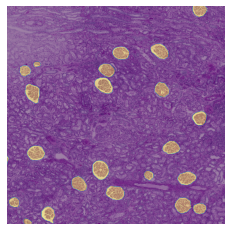

In [9]:
img_num = 0
resize = PARAMS["resize"]
shft = 0.6
wnd = PARAMS["img_size"] * larger
img = tiff.imread(os.path.join(f"{DATA_PATH}/train", df_masks.index[img_num] + ".tiff"))
if len(img.shape) == 5: img = np.transpose(img.squeeze(), (1, 2, 0))
mask = enc2mask(df_masks.iloc[img_num], (img.shape[1], img.shape[0]))
print(img.shape, mask.shape)
img = cv2.resize(img,
                 (img.shape[1] // resize, img.shape[0] // resize),
                 interpolation = cv2.INTER_AREA)
mask = cv2.resize(mask,
                  (mask.shape[1] // resize, mask.shape[0] // resize),
                  interpolation = cv2.INTER_NEAREST)
img = img[int(img.shape[0] * shft) : int(img.shape[0] * shft) + wnd,
          int(img.shape[1] * shft) : int(img.shape[1] * shft) + wnd,
          :]
mask = mask[int(mask.shape[0] * shft) : int(mask.shape[0] * shft) + wnd,
            int(mask.shape[1] * shft) : int(mask.shape[1] * shft) + wnd]
plt.figure(figsize = (4, 4))
plt.axis("off")
plt.imshow(img)
print(img.shape)
plt.imshow(mask, alpha = 0.4)
plt.show()

In [17]:
def dice_np(pred, true, k = 1):
    intersection = np.sum(pred[true == k]) * 2
    dice = intersection / (np.sum(pred) + np.sum(true))
    return dice

def get_dice(mask, mask_lrg, th):
    mask_pred = np.squeeze(mask_lrg > th).astype(int)
    return dice_np(mask, mask_pred)

def get_best_th_dice(mask, mask_lrg, n=100, plot = False):
    thresholds = np.linspace(0, 1, n)
    dices = [get_dice(mask, mask_lrg, th) for th in thresholds]
    n_max = np.argmax(dices)
    if plot:
        plt.plot(thresholds, dices)
        plt.title(f"th: {thresholds[n_max]:.2f} dice: {dices[n_max]:.2f}")
        plt.show()
    return thresholds, dices, n_max

In [11]:
masks_lrg = []
for j in range(len(test_models)):
    mask_lrg = test_models[j].predict(img[np.newaxis, ] / 255).astype(np.float32)
    masks_lrg.append(mask_lrg)

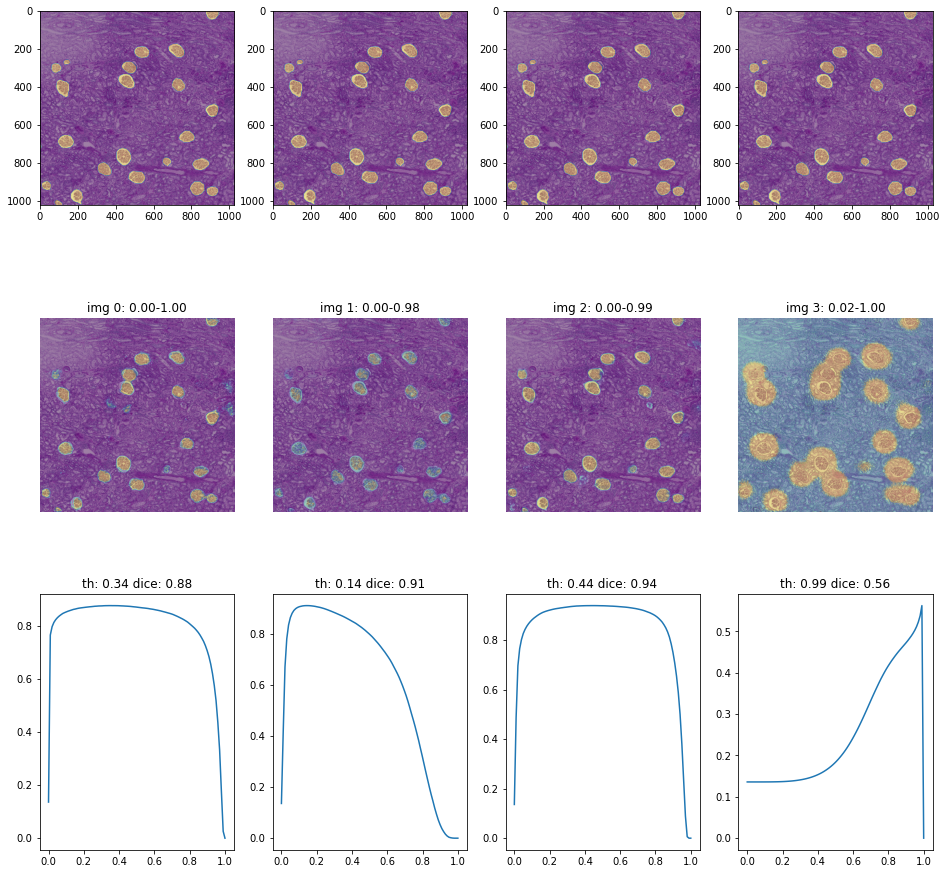

In [24]:
fig, axes = plt.subplots(figsize = (16, 16), nrows = 3, ncols = len(test_models))
if len(test_models) == 1:
    for j in range(len(test_models)):
        mask_lrg = masks_lrg[j]
        axes[0].imshow(img)
        axes[0].imshow(mask, alpha = 0.4)
        axes[1].imshow(img)
        axes[1].imshow(np.squeeze(mask_lrg), alpha = 0.4)
        axes[1].set_title(f"img {j}: {np.min(mask_lrg):.2f}-{np.max(mask_lrg):.2f}")
        axes[1].axis("off")
        thresholds,dices, n_max = get_best_th_dice(mask, mask_lrg, n=100, plot = False)
        axes[2].plot(thresholds, dices)
        axes[2].set_title(f"th: {thresholds[n_max]:.2f} dice: {dices[n_max]:.2f}")
    plt.show()
else:
    for j in range(len(test_models)):
        mask_lrg = masks_lrg[j]
        axes[0,j].imshow(img)
        axes[0,j].imshow(mask, alpha = 0.4)
        axes[1,j].imshow(img)
        axes[1,j].imshow(np.squeeze(mask_lrg), alpha = 0.4)
        axes[1,j].set_title(f"img {j}: {np.min(mask_lrg):.2f}-{np.max(mask_lrg):.2f}")
        axes[1,j].axis("off")
        thresholds,dices, n_max = get_best_th_dice(mask, mask_lrg, n=100, plot = False)
        axes[2,j].plot(thresholds, dices)
        axes[2,j].set_title(f"th: {thresholds[n_max]:.2f} dice: {dices[n_max]:.2f}")
    plt.show()
    

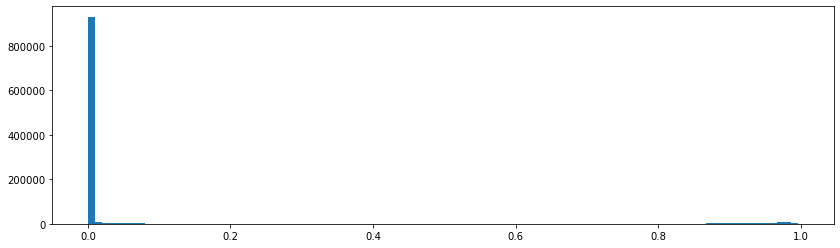

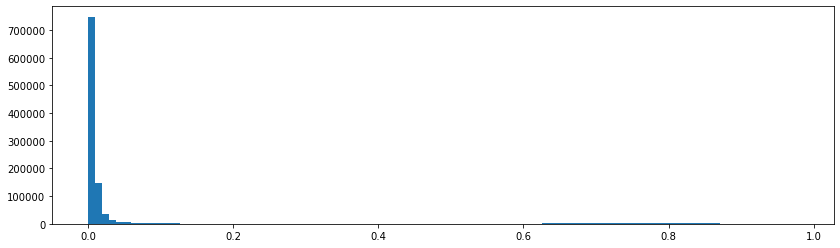

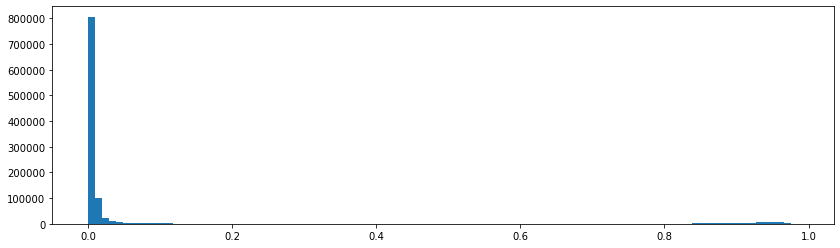

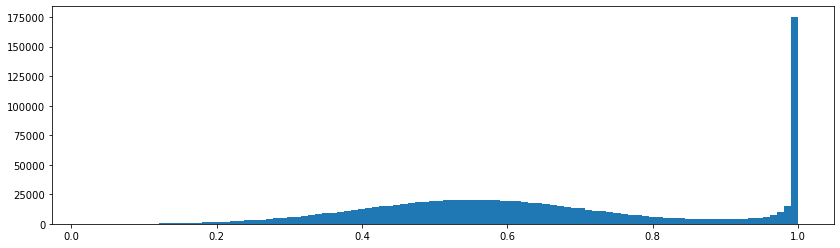

In [25]:
for mask_lrg in masks_lrg:
    plt.figure(figsize = (14, 4))
    plt.hist(mask_lrg.flatten(), bins = 100)
    plt.show()

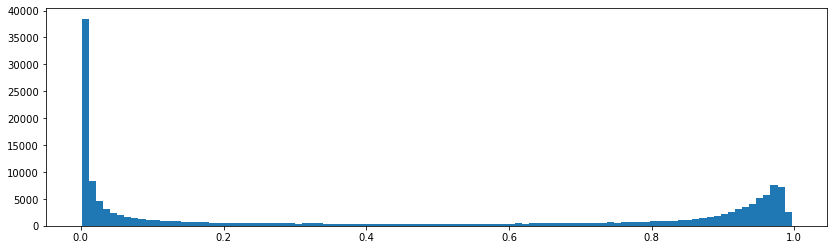

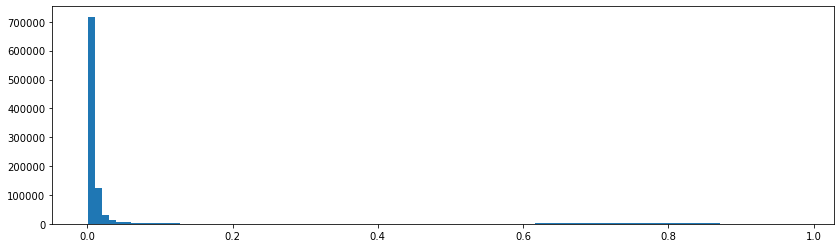

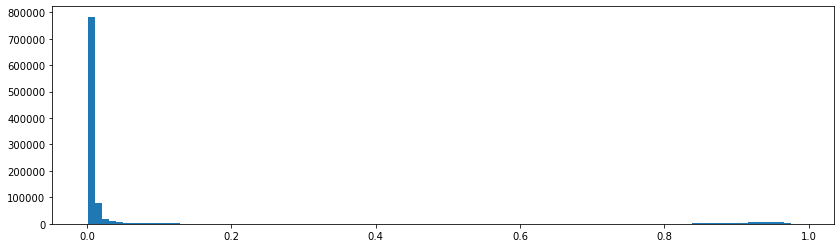

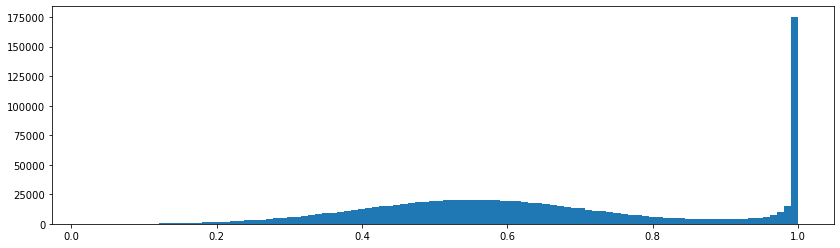

In [26]:
for mask_lrg in masks_lrg:
    plt.figure(figsize = (14, 4))
    plt.hist(np.where(mask_lrg < 10e-4, np.nan, mask_lrg).flatten(), bins = 100)
    plt.show()